In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
import util, defs, models

In [7]:
def proper_phi(phi):
    return np.arctan2(np.sin(phi),np.cos(phi))

def z(s,b):
    return np.sqrt(2*((s+b)*np.log(1+s/b)-s))

In [8]:
def sort_constituents(x):
    #pt, eta, phi = np.split(x, 3, axis=-1)
    pt = x[:,:,0]
    eta = x[:,:,1]
    phi = x[:,:,2]
    
    idxs_sort = np.argsort(pt, axis=-1)[:,::-1]

    pt_sort = np.take_along_axis(pt,idxs_sort,axis=1)
    eta_sort = np.take_along_axis(eta,idxs_sort,axis=1)
    phi_sort = np.take_along_axis(phi,idxs_sort,axis=1)

    return np.stack([pt_sort,eta_sort,phi_sort], axis=2)

In [9]:
JET_PT_MIN = 1.2*defs.JET_PT_MIN
JET_MASS_MIN = 1.2*defs.JET_MASS_MIN

bg_consts, sig_consts, bg_jets, sig_jets = util.load_data(jet_pt_min=JET_PT_MIN, jet_mass_min=JET_MASS_MIN)
    
print(bg_consts.shape)
print(sig_consts.shape)

(124708, 64, 3)
(191465, 64, 3)


In [10]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)
X_train.shape

(212004, 64, 3)

In [263]:
def mk_adversary(benchmark_file, n_layer=4, n_units=300, epsilons=(1,1,1), input_shape=None,
                 shuffle_particles=False, randomize_phi=False,
                 attack_sig_only=True, preserve_bg_only=True, calc_D2=True,
                 transcode_latent=None, can_create=False, use_jet_pT=False,
                 unconditional=False, random_latent=8, attack_validation=None,
                 bottleneck=None):
    benchmark = keras.models.load_model(benchmark_file,
                                        custom_objects=dict(tf=tf,
                                                            JetVector=util.JetVector,
                                                            JetECF=util.JetECF))
    benchmark.name = 'benchmark'
    
    if input_shape is None:
        input_shape = np.int_(benchmark.get_input_at(0).shape[1:])
        
    adv_input = layers.Input(input_shape)
    
    x = adv_input
        
    if transcode_latent is None:
        if unconditional:
            def mk_random(x):
                return tf.random_normal((tf.shape(x)[0], random_latent), stddev=0.1)
            x = layers.Lambda(mk_random)(x)
        else:
            x = layers.Flatten()(x)
        
        if bottleneck:
            for _ in range(n_layer//2):
                x = layers.Dense(n_units, activation='relu')(x)
            x = layers.Dense(bottleneck)(x)
            for _ in range(n_layer//2):
                x = layers.Dense(n_units, activation='relu')(x)
        else:
            for _ in range(n_layer):
                x = layers.Dense(n_units, activation='relu')(x)

        x = layers.Dense(np.prod(input_shape))(x)
        x = layers.Reshape(input_shape)(x)

        def add_deltas(x):
            x_old = x[0]
            dx = x[1]
            jet = x[2]

            pt_old, eta_old, phi_old = tf.split(x_old, 3, axis=-1)
            dpt, deta, dphi = tf.split(dx, 3, axis=-1)

            jet_pt, jet_eta, jet_phi, jet_mass = tf.split(jet, 4, axis=-1)

            zeros = tf.zeros_like(pt_old)

            # try something new... add pT in units of jet mass
            #pt_new = tf.clip_by_value(pt_old*(1+epsilons[0]*tf.tanh(dpt)), defs.MIN_PT, 9e9)
            #jpt = tf.reduce_sum(pt_old, axis=-2, keepdims=True)
            jpt = tf.reshape(jet_pt, (-1,1,1))
            jeta = tf.reshape(jet_eta, (-1,1,1))
            jphi = tf.reshape(jet_phi, (-1,1,1))

            was_valid = pt_old>0

            if not can_create:
                pt_new = pt_old*(1 + epsilons[0]*tf.tanh(dpt))
                pt_new = tf.where(was_valid, pt_new, zeros)
            else:
                pt_new = pt_old + epsilons[0]*jpt*tf.tanh(dpt)

            eeta = epsilons[1]*tf.tanh(deta)
            eta_new_ext = eta_old + eeta
            eta_new_next = jeta + eeta
            eta_new = tf.where(was_valid, eta_new_ext, eta_new_next)

            ephi = epsilons[2]*tf.tanh(dphi)
            phi_new_ext = phi_old + ephi
            phi_new_next = jphi + ephi
            phi_new = tf.where(was_valid, phi_new_ext, phi_new_next)

            #is_valid = pt_old>0
            is_valid = pt_new>defs.MIN_PT
            pt_new = tf.where(is_valid, pt_new, zeros)
            eta_new = tf.where(is_valid, eta_new, zeros)
            phi_new = tf.where(is_valid, phi_new, zeros)

            return tf.concat([pt_new, eta_new, phi_new], axis=-1)

        tmp_jet = util.JetVector()(adv_input)

        adv_output = layers.Lambda(add_deltas)([adv_input, x, tmp_jet])
    else:
        x = layers.Flatten()(x)
        for _ in range(n_layer):
            x = layers.Dense(n_units, activation='relu')(x)
        x = layers.Dense(transcode_latent)(x)
        for _ in range(n_layer):
            x = layers.Dense(n_units, activation='relu')(x)
        
        input_shape_mod = (input_shape[0], 4)
        x = layers.Dense(np.prod(input_shape_mod))(x)
        x = layers.Reshape(input_shape_mod)(x)
        
        def fix_outputs(x):
            pt,eta,phi0,phi1 = tf.split(x, 4, axis=-1)
            eta = 5*tf.tanh(eta)
            phi0 = tf.tanh(phi0)
            phi1 = tf.tanh(phi1)
            phi = tf.atan2(phi1,phi0)
            
            zeros = tf.zeros_like(pt)
            is_valid = pt>defs.MIN_PT
            pt = tf.where(is_valid, pt, zeros)
            eta = tf.where(is_valid, eta, zeros)
            phi = tf.where(is_valid, phi, zeros)
            return tf.concat([pt,eta,phi], axis=-1)
        
        x = layers.Lambda(fix_outputs)(x)
        
        adv_output = x
        
    adversary = Model(adv_input, adv_output, name='adversary')
    
    
    #calc_input = layers.Input(input_shape)
    #x1 = util.JetVector()(calc_input)
    #x2 = util.JetECF()(model_input)
    #d2 = layers.Lambda(lambda x: x[:,3:4]/100.)(x2) # NB: scaling D2 by 1/100
    #model_output = layers.Concatenate(axis=-1)([x1,d2])
    #calc_output = x1
    #calc = Model(calc_input, calc_output)
    if calc_D2:
        calc = models.mk_HL_calc()
    else:
        calc = models.mk_HL_calc(features=('pt','eta','phi','mass'))
    
    
    def shuffle(x):
        x = tf.transpose(x, (1,0,2))
        x = tf.random_shuffle(x)
        x = tf.transpose(x, (1,0,2))
        return x
    
    
    benchmark.trainable = False
    composite_input = layers.Input(input_shape)
    pre_x = composite_input
    if shuffle_particles:
        pre_x = layers.Lambda(shuffle)(pre_x)
    
    if randomize_phi:
        pre_x = util.RandomizeAngle(idxs=2)(pre_x)
        def fix_phi(x):
            pt,eta,phi = tf.split(x,3,axis=-1)
            s = tf.sin(phi)
            c = tf.cos(phi)
            phi = tf.atan2(s,c)
            is_valid = pt>0
            zeros = tf.zeros_like(eta)
            eta = tf.where(is_valid, eta, zeros)
            phi = tf.where(is_valid, phi, zeros)
            return tf.concat([pt,eta,phi], axis=-1)
        pre_x = layers.Lambda(fix_phi, name='fix_phi')(pre_x)
    adv_x = adversary(pre_x)
    adv_dx = layers.subtract([adv_x, pre_x])
    composite_output = benchmark(adv_x)
    cls_output = benchmark(pre_x)
    jet_before = calc(pre_x)
    jet_after = calc(adv_x)
    composite = Model(composite_input, composite_output, name='composite')
    
    def adv_loss(y1,y2):
        xent = keras.losses.binary_crossentropy(tf.zeros_like(composite_output), composite_output)
        if attack_validation:
            is_sig_like = K.squeeze(cls_output,axis=1)>attack_validation
            return K.mean(tf.where(is_sig_like, xent, tf.zeros_like(xent)))
        elif attack_sig_only:
            is_sig_like = K.squeeze(y1,axis=1)>0.5
            return K.mean(tf.where(is_sig_like, xent, tf.zeros_like(xent)))
        else:
            return K.mean(xent)
        
    def bg_loss(y1,y2):
        mse = K.squeeze(K.square(composite_output-cls_output),axis=1)
        if attack_validation:
            is_bg_like = K.squeeze(cls_output, axis=1)<attack_validation
        else:
            is_bg_like = K.squeeze(y1,axis=1)<0.5
        return K.mean(tf.where(is_bg_like, mse, tf.zeros_like(mse)))
    
    def jpt_loss(y1,y2):
        mse = K.square((jet_before[:,0] - jet_after[:,0])/jet_before[:,0])
        if attack_validation:
            is_bg_like = K.squeeze(cls_output,axis=1)<attack_validation
            return K.mean(tf.where(is_bg_like, mse, tf.zeros_like(mse)))
        elif preserve_bg_only:
            is_bg_like = K.squeeze(y1,axis=1)<0.5
            return K.mean(tf.where(is_bg_like, mse, tf.zeros_like(mse)))
        else:
            return K.mean(mse)
    def jmass_loss(y1,y2):
        mse = K.square(jet_before[:,3] - jet_after[:,3])
        if attack_validation:
            is_bg_like = K.squeeze(cls_output, axis=1) < attack_validation
            return K.mean(tf.where(is_bg_like, mse, tf.zeros_like(mse)))
        elif preserve_bg_only:
            is_bg_like = K.squeeze(y1,axis=1)<0.5
            return K.mean(tf.where(is_bg_like, mse, tf.zeros_like(mse)))
        else:
            return K.mean(mse)
    
    def jmass_res(y1,y2):
        pull = (jet_before[:,0] - jet_after[:,0])/jet_before[:,0]
        if attack_validation:
            is_bg_like = K.squeeze(cls_output, axis=1) < attack_validation
            return K.mean(tf.where(is_bg_like, pull, tf.zeros_like(pull)))
        elif preserve_bg_only:
            is_bg_like = K.squeeze(y1,axis=1)<0.5
            return K.std(tf.where(is_bg_like, 2*pull, tf.zeros_like(pull)))
        else:
            return K.std(pull)
    
    composite.lambda_adv = K.variable(1.0)
    composite.lambda_bg = K.variable(1.0)
    composite.lambda_jpt = K.variable(0.0)
    composite.lambda_jmass = K.variable(0.0)
    
    def loss(y1,y2):
        return composite.lambda_adv * adv_loss(y1,y2) + \
               composite.lambda_bg * bg_loss(y1,y2) + \
               composite.lambda_jpt * jpt_loss(y1,y2) + \
               composite.lambda_jmass * jmass_loss(y1,y2)
           
    
    composite.compile(optimizer='adam', loss=loss, metrics=[adv_loss, bg_loss, jpt_loss, jmass_loss, jmass_res])
    composite.loss_ptr = loss
    
    composite.adversary = adversary
    composite.calc = calc
    
    return benchmark, adversary, composite, calc

In [264]:
def gen_data(X, y, batch_size):
    idxs_bg = np.argwhere(y==0).squeeze()
    idxs_sig = np.argwhere(y==1).squeeze()
    
    nbatch = int(min(len(idxs_bg)//batch_size, len(idxs_sig)//batch_size))
    
    while True:
        np.random.shuffle(idxs_bg)
        np.random.shuffle(idxs_sig)
        for ibatch in range(nbatch):
            ibg = idxs_bg[ibatch*batch_size:(ibatch+1)*batch_size]
            isig = idxs_sig[ibatch*batch_size:(ibatch+1)*batch_size]
            yield X[ibg], y[ibg]
            yield X[isig], y[isig]

In [517]:
K.clear_session()
#model_file = 'model_benchmark_HL_calc_32.h5'
#model_file = 'model_benchmark_PFN_64.h5'
model_file = 'model_benchmark_PFN_%d.h5'%defs.N_CONST

calc_D2 = False

#epsilons = (0.05, 0.05, 0.05)
epsilons = (0.02, 0.02, 0.02)

benchmark, adversary, composite, calc = mk_adversary(model_file,
                                                     #epsilons=(0.5,0.5,0.5),
                                                     epsilons=epsilons,
                                                     input_shape=(defs.N_CONST,3),
                                                     preserve_bg_only=True,
                                                     attack_sig_only=True,
                                                     randomize_phi=True,
                                                     calc_D2=calc_D2,
                                                     bottleneck=None,
                                                     transcode_latent=None,
                                                     unconditional=False,
                                                     attack_validation=None)

hl_val = calc.predict(X_val, batch_size=256)
preds_val = benchmark.predict(X_val, batch_size=256)
composite.h = util.HistoryCB(val_data=(X_val, y_val), ks_ref=preds_val,
                             pt_ref=hl_val[:,0], mass_ref=hl_val[:,3],
                             live_metrics=['adv_loss','bg_loss', 'jpt_loss', 'jmass_loss',
                                           'val_ks_bg','val_ks_sig','val_pt_ks_bg','val_mass_ks_bg'])
composite.h.live_layout = (5,2)
composite.h.live_figsize = 2.5*plt.figaspect(0.7)

In [518]:
composite.summary()
#composite.layers[1].summary()

Model: "composite"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 3)             0         
_________________________________________________________________
randomize_angle_1 (Randomize (None, 64, 3)             0         
_________________________________________________________________
fix_phi (Lambda)             (None, 64, 3)             0         
_________________________________________________________________
adversary (Model)            (None, 64, 3)             386592    
_________________________________________________________________
benchmark (Model)            (None, 1)                 462081    
Total params: 848,673
Trainable params: 386,592
Non-trainable params: 462,081
_________________________________________________________________


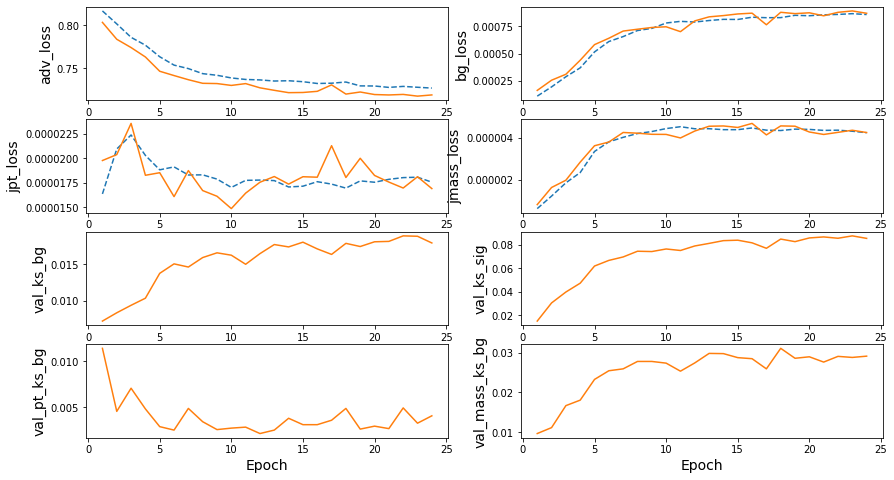

In [587]:
epochs = 8

batch_size = 512 #256 #320
lr = 3e-4

lambda_adv   = 1e-2
lambda_bg    = 3e-1 #64
lambda_jpt   = 0.5 #16
lambda_jmass = 2 #64

K.set_value(composite.optimizer.lr, lr)

K.set_value(composite.lambda_adv, lambda_adv)
K.set_value(composite.lambda_bg, lambda_bg)
K.set_value(composite.lambda_jpt, lambda_jpt)
K.set_value(composite.lambda_jmass, lambda_jmass)

composite.h.live_nskip = 0

use_gen = False
if use_gen:
    composite.fit_generator(gen_data(X_train, y_train, batch_size=batch_size),
                            validation_data = gen_data(X_val, y_val, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0]//batch_size,
                            validation_steps=X_val.shape[0]//batch_size,
                            epochs=epochs,
                            callbacks=[composite.h],
                           )
else:
    composite.fit(X_train, y_train, validation_data=(X_val, y_val),
                  batch_size=batch_size, epochs=epochs, callbacks=[composite.h])

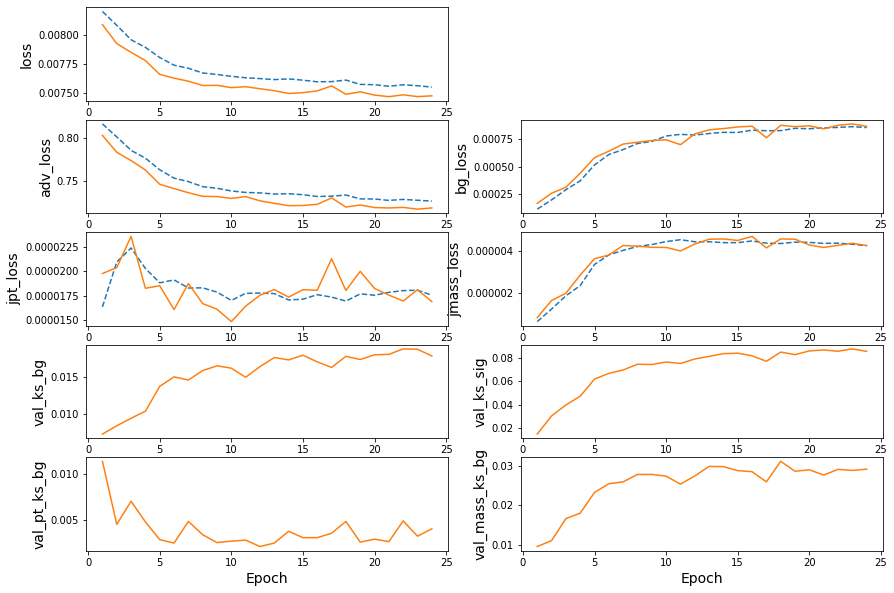

In [588]:
composite.h.plot([
    'loss', None,
    'adv_loss', 'bg_loss',
    'jpt_loss', 'jmass_loss',
    'val_ks_bg','val_ks_sig',
    'val_pt_ks_bg', 'val_mass_ks_bg'], nskip=composite.h.live_nskip,
           figsize=2.5*plt.figaspect(0.7), layout=(5,2))

BENCHMARK AUC: 0.8659309971995554
ADV AUC:       0.856909450286298
ADV+SORT AUC:  0.8569094459995358
KS (BG):       Ks_2sampResult(statistic=0.013845824869025969, pvalue=0.05541290717356076)
KS (SIG):      Ks_2sampResult(statistic=0.07580455468833525, pvalue=4.1528215850227243e-47)


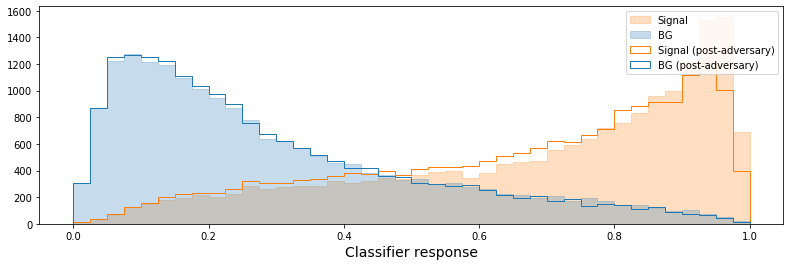

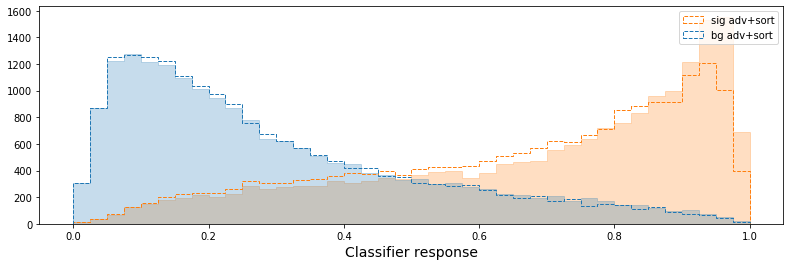

In [589]:
x_adv = adversary.predict(X_val, batch_size=256)
preds_adv = benchmark.predict(x_adv, batch_size=256)
x_adv_sort = sort_constituents(x_adv)
preds_adv_sort = benchmark.predict(x_adv_sort, batch_size=256)

print("BENCHMARK AUC:", roc_auc_score(y_val, preds_val))
print("ADV AUC:      ", roc_auc_score(y_val, preds_adv))
print("ADV+SORT AUC: ", roc_auc_score(y_val, preds_adv_sort))
print("KS (BG):      ", ks_2samp(preds_val[y_val==0,0], preds_adv[y_val==0,0]))
print("KS (SIG):     ", ks_2samp(preds_val[y_val==1,0], preds_adv[y_val==1,0]))



plt.figure(figsize=plt.figaspect(0.3))
plt.hist([preds_val[y_val==0,0], preds_val[y_val==1,0]], bins=40, range=(0,1), histtype='step', fill=True, alpha=0.25, label=['BG', 'Signal']);
plt.hist([preds_adv[y_val==0,0], preds_adv[y_val==1,0]], bins=40, range=(0,1), histtype='step', color=['C0','C1'],label=['BG (post-adversary)','Signal (post-adversary)']);
plt.xlabel("Classifier response")
plt.legend()
plt.savefig('adv_classifer_response.pdf')
plt.figure(figsize=plt.figaspect(0.3))
plt.hist([preds_val[y_val==0,0], preds_val[y_val==1,0]], bins=40, range=(0,1), histtype='step', fill=True, alpha=0.25);
plt.hist([preds_adv_sort[y_val==0,0], preds_adv_sort[y_val==1,0]], bins=40, range=(0,1), histtype='step', color=['C0','C1'], ls='--',label=['bg adv+sort', 'sig adv+sort']);
plt.xlabel("Classifier response")
plt.legend();

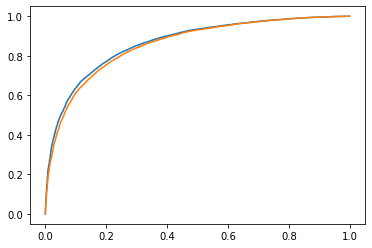

In [590]:
from sklearn.metrics import roc_curve

x,y = roc_curve(y_val, preds_val)[:2]
plt.plot(x,y,label='before')
x,y = roc_curve(y_val, preds_adv)[:2]
plt.plot(x,y,label='after');

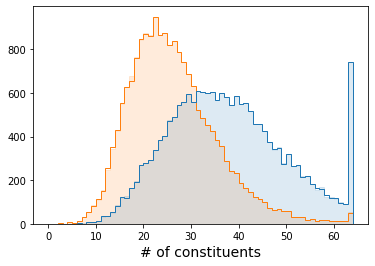

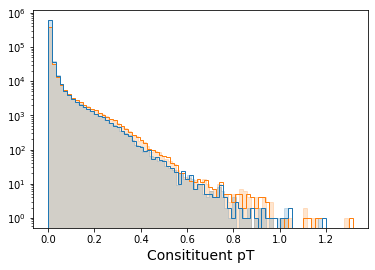

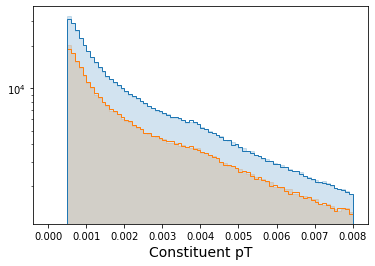

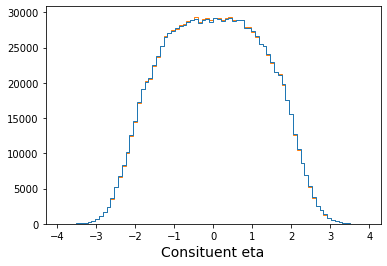

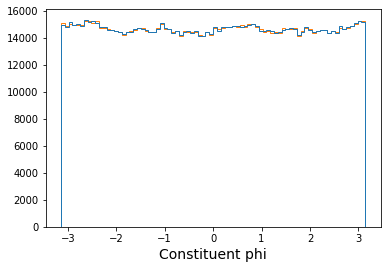

In [591]:
pt_val = X_val[:,:,0]
pt_val_bg = pt_val[y_val==0]
pt_val_sig = pt_val[y_val==1]
pt_adv = x_adv[:,:,0]
pt_adv_bg = pt_adv[y_val==0]
pt_adv_sig = pt_adv[y_val==1]
eta_val = X_val[:,:,1]
eta_adv = x_adv[:,:,1]
phi_val = X_val[:,:,2]
phi_adv = x_adv[:,:,2]

plt.hist([np.sum(pt_val_bg>0, axis=1), np.sum(pt_val_sig>0, axis=1)], histtype='step', bins=defs.N_CONST, range=(0,defs.N_CONST), fill=True, alpha=0.15);
plt.hist([np.sum(pt_adv_bg>0, axis=1), np.sum(pt_adv_sig>0, axis=1)], histtype='step', bins=defs.N_CONST, range=(0,defs.N_CONST), color=('C0','C1'));

plt.xlabel("# of constituents")
plt.figure()
plt.hist([pt_val_bg[pt_val_bg>0], pt_val_sig[pt_val_sig>0]], histtype='step', bins=80, fill=True, alpha=0.2);
plt.hist([pt_adv_bg[pt_adv_bg>0], pt_adv_sig[pt_adv_sig>0]], histtype='step', bins=80, color=('C0','C1'));
plt.xlabel("Consitituent pT")
plt.yscale('log');
plt.figure()
plt.hist([pt_val_bg[pt_val_bg>0], pt_val_sig[pt_val_sig>0]], histtype='step', bins=80, range=(0,0.008), fill=True, alpha=0.2);
plt.hist([pt_adv_bg[pt_adv_bg>0], pt_adv_sig[pt_adv_sig>0]], histtype='step', bins=80, range=(0,0.008), color=('C0','C1'));
plt.xlabel("Constituent pT")
plt.yscale('log');
plt.figure()
plt.hist([eta_val[pt_val>0], eta_adv[pt_adv>0]], histtype='step', bins=80);
plt.xlabel("Consituent eta")
plt.figure()
plt.hist([proper_phi(phi_val[pt_val>0]), proper_phi(phi_adv[pt_adv>0])], histtype='step', bins=80);
plt.xlabel("Constituent phi");

/ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


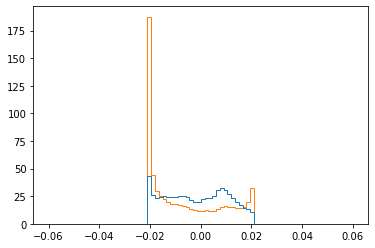

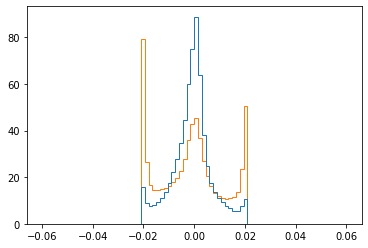

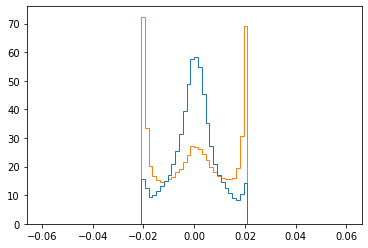

In [592]:
pt_delta = (pt_adv-pt_val)/pt_val
pt_delta_bg = pt_delta[y_val==0][pt_val[y_val==0]>0]
pt_delta_sig = pt_delta[y_val==1][pt_val[y_val==1]>0]
plt.hist([pt_delta_bg, pt_delta_sig], histtype='step', bins=80, range=(-0.06,0.06), density=True);

phi_delta = phi_adv-phi_val
phi_delta_bg = phi_delta[y_val==0][pt_val[y_val==0]>0]
phi_delta_sig = phi_delta[y_val==1][pt_val[y_val==1]>0]
plt.figure()
plt.hist([phi_delta_bg, phi_delta_sig], histtype='step', bins=80, range=(-0.06,0.06), density=True);

eta_delta = eta_adv-eta_val
eta_delta_bg = eta_delta[y_val==0][pt_val[y_val==0]>0]
eta_delta_sig = eta_delta[y_val==1][pt_val[y_val==1]>0]
plt.figure()
plt.hist([eta_delta_bg, eta_delta_sig], histtype='step', bins=80, range=(-0.06,0.06), density=True);

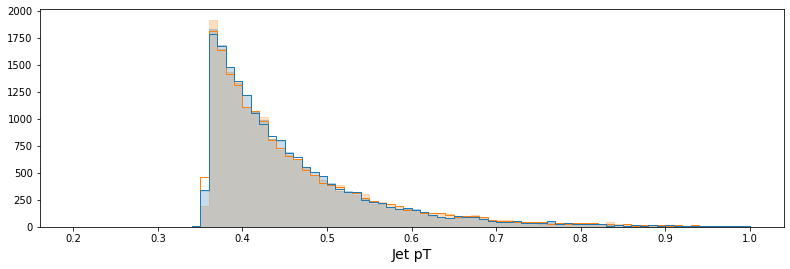

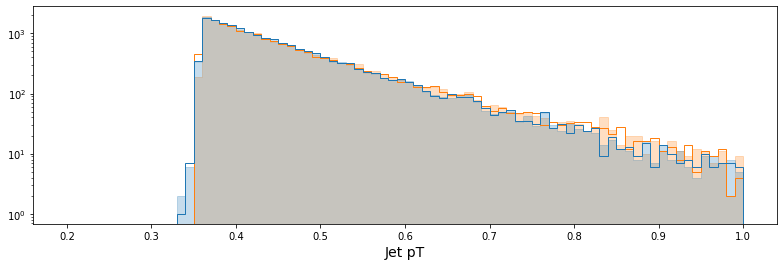

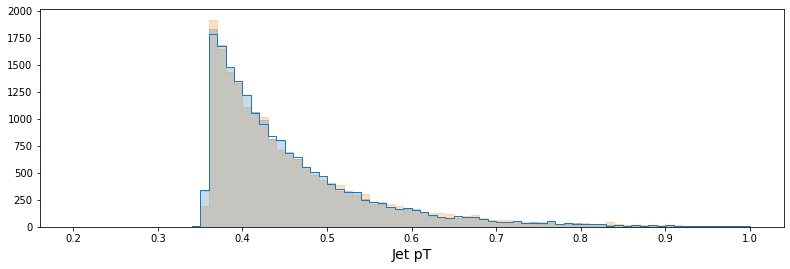

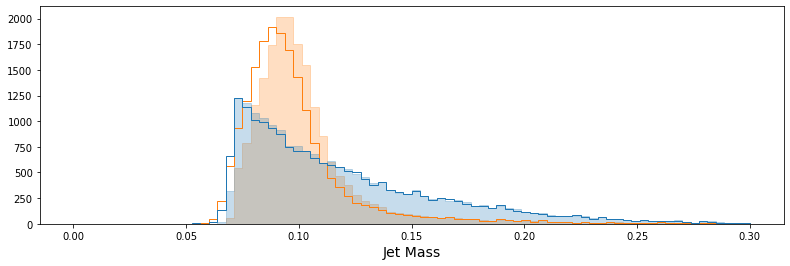

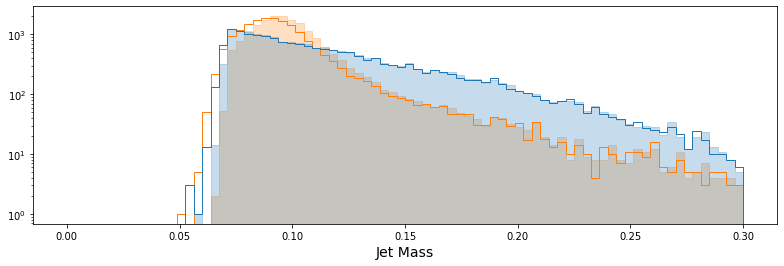

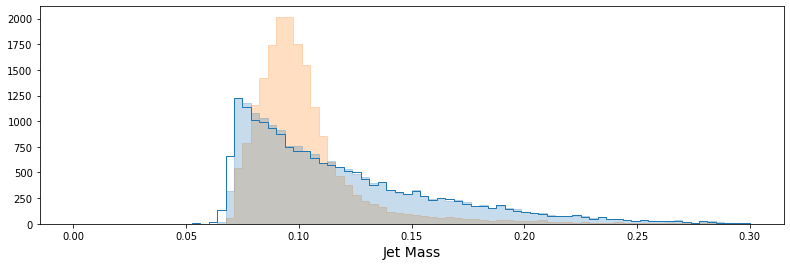

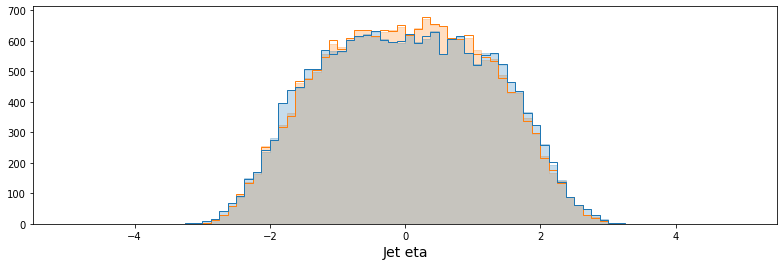

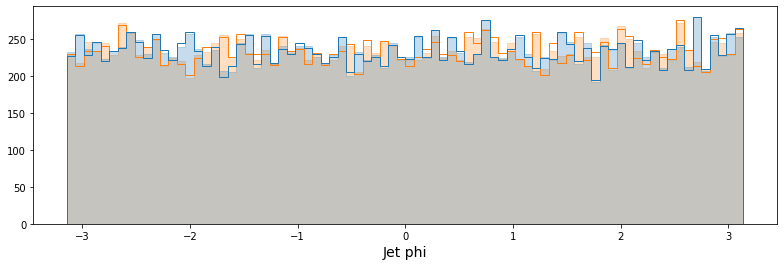

In [593]:
hl_adv = calc.predict(x_adv, batch_size=256)

jpt_val = hl_val[:,0]
jpt_adv = hl_adv[:,0]
jeta_val = hl_val[:,1]
jeta_adv = hl_adv[:,1]
jphi_val = hl_val[:,2]
jphi_adv = hl_adv[:,2]
jmass_val = hl_val[:,3]
jmass_adv = hl_adv[:,3]
if calc_D2:
    jd2_val = hl_val[:,4]
    jd2_adv = hl_adv[:,4]
    
pass_val = (jpt_val>JET_PT_MIN)*(jmass_val>JET_MASS_MIN)
pass_adv = (jpt_adv>JET_PT_MIN)*(jmass_adv>JET_MASS_MIN)

plt.figure(figsize=plt.figaspect(0.3));
plt.hist([jpt_val[y_val==0], jpt_val[y_val==1]], histtype='step', bins=80, range=(0.2,1.), fill=True, alpha=0.25)
plt.hist([jpt_adv[y_val==0], jpt_adv[y_val==1]], histtype='step', bins=80, range=(0.2,1.), color=('C0','C1'))
plt.xlabel("Jet pT")
plt.figure(figsize=plt.figaspect(0.3))
plt.hist([jpt_val[y_val==0], jpt_val[y_val==1]], histtype='step', bins=80, range=(0.2,1.), fill=True, alpha=0.25);
plt.hist([jpt_adv[y_val==0], jpt_adv[y_val==1]], histtype='step', bins=80, range=(0.2,1.), color=('C0','C1'));
plt.xlabel("Jet pT")
plt.yscale('log');
plt.figure(figsize=plt.figaspect(0.3));
plt.hist([jpt_val[y_val==0],jpt_val[y_val==1]], histtype='step', bins=80, range=(0.2,1.), fill=True, alpha=0.25)
plt.hist(jpt_adv[y_val==0], histtype='step', bins=80, range=(0.2,1.), color='C0')
plt.xlabel("Jet pT")

plt.figure(figsize=plt.figaspect(0.3));
plt.hist([jmass_val[y_val==0], jmass_val[y_val==1]], histtype='step', bins=80, range=(0,0.3), fill=True, alpha=0.25);
plt.hist([jmass_adv[y_val==0], jmass_adv[y_val==1]], histtype='step', bins=80, range=(0,0.3), color=('C0','C1'));
plt.xlabel("Jet Mass")
plt.figure(figsize=plt.figaspect(0.3));
plt.hist([jmass_val[y_val==0], jmass_val[y_val==1]], histtype='step', bins=80, range=(0,0.3), fill=True, alpha=0.25);
plt.hist([jmass_adv[y_val==0], jmass_adv[y_val==1]], histtype='step', bins=80, range=(0,0.3), color=('C0','C1'));
plt.xlabel("Jet Mass");
plt.yscale('log');
plt.figure(figsize=plt.figaspect(0.3));
plt.hist([jmass_val[y_val==0],jmass_val[y_val==1]], histtype='step', bins=80, range=(0,0.3), fill=True, alpha=0.25);
plt.hist(jmass_adv[y_val==0], histtype='step', bins=80, range=(0,0.3), color='C0');
plt.xlabel("Jet Mass")

plt.figure(figsize=plt.figaspect(0.3))
plt.hist([jeta_val[y_val==0], jeta_val[y_val==1]], histtype='step', bins=80, range=(-5,5), fill=True, alpha=0.25);
plt.hist([jeta_adv[y_val==0], jeta_adv[y_val==1]], histtype='step', bins=80, range=(-5,5), color=('C0','C1'));
plt.xlabel("Jet eta")
plt.figure(figsize=plt.figaspect(0.3))
plt.hist([jphi_val[y_val==0], jphi_val[y_val==1]], histtype='step', bins=80, fill=True, alpha=0.25);
plt.hist([jphi_adv[y_val==0], jphi_adv[y_val==1]], histtype='step', bins=80, color=('C0','C1'));
plt.xlabel("Jet phi")

if calc_D2:
    plt.figure(figsize=plt.figaspect(0.3))
    plt.hist([jd2_val[y_val==0], jd2_val[y_val==1]], histtype='step', bins=80, range=(0,10), fill=True, alpha=0.25);
    plt.hist([jd2_adv[y_val==0], jd2_adv[y_val==1]], histtype='step', bins=80, range=(0,10), color=('C0','C1'));
    plt.xlabel("Jet D2")
    plt.yscale('log');
    plt.figure(figsize=plt.figaspect(0.3))
    plt.hist([jd2_val[y_val==0], jd2_val[y_val==1]], histtype='step', bins=80, range=(0,1), fill=True, alpha=0.25);
    plt.hist([jd2_adv[y_val==0], jd2_adv[y_val==1]], histtype='step', bins=80, range=(0,1), color=('C0','C1'));
    plt.xlabel("Jet D2")
    plt.figure(figsize=plt.figaspect(0.3))
    plt.hist([jd2_val[y_val==0], jd2_val[y_val==1]], histtype='step', bins=80, range=(0,0.1), fill=True, alpha=0.25);
    plt.hist([jd2_adv[y_val==0], jd2_adv[y_val==1]], histtype='step', bins=80, range=(0,0.1), color=('C0','C1'));
    plt.xlabel("Jet D2");

Number of 'data' events: 3697
KS clean (BG):   Ks_2sampResult(statistic=0.015406898164238292, pvalue=0.030625867690981228)
KS clean (SIG):  Ks_2sampResult(statistic=0.07454403673835486, pvalue=1.929311228906222e-43)
KS data/mc (BG): Ks_2sampResult(statistic=0.033190256692180786, pvalue=0.05986839751805098)

chi^2 (NN output) = 29.750; ndf=32
chi^2 (jet pT)    = 62.018; ndf=40
chi^2 (jet mass)  = 44.558; ndf=40


/ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
/ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in true_divide


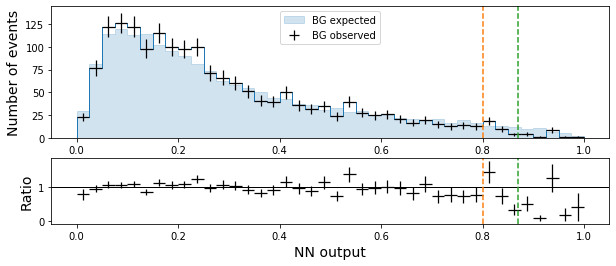

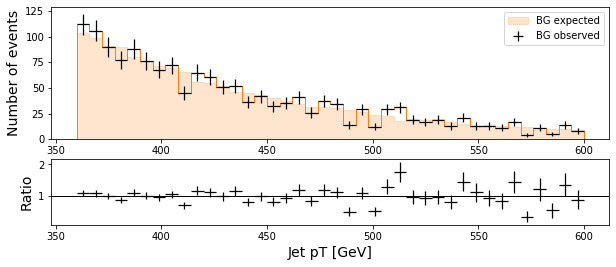

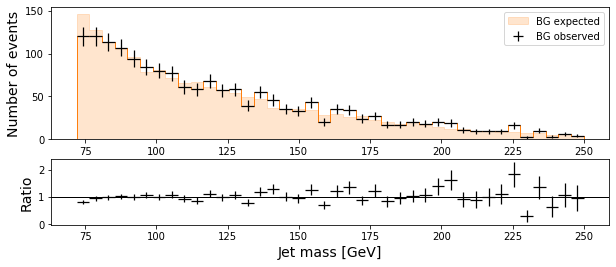

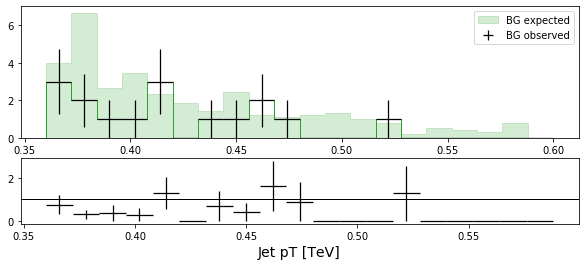

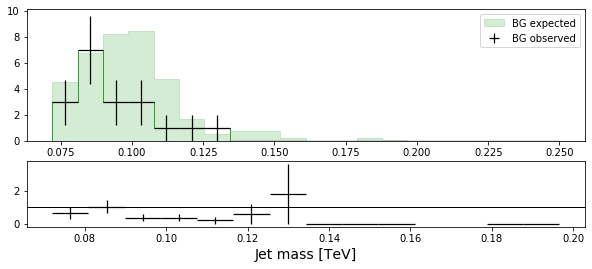

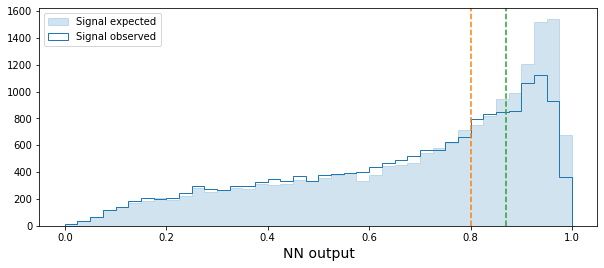

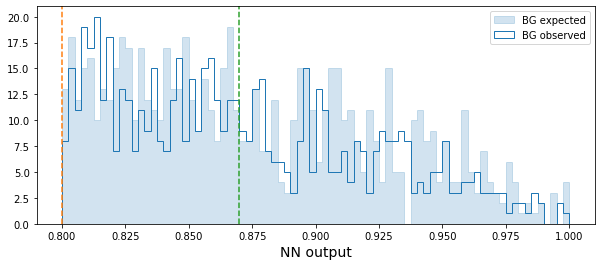

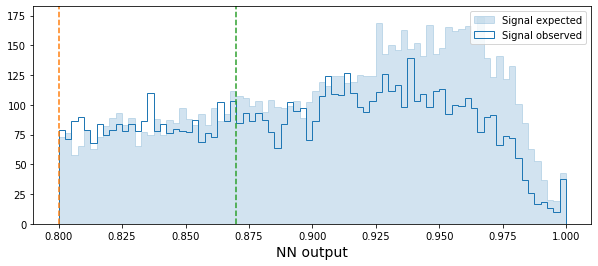

In [629]:
norm = False

CR = 0.8
SR = 0.87

#stat_factor = bg_scale
stat_factor = 0.1

is_data = np.random.rand(len(preds_val))<stat_factor
preds_mc = preds_val[(y_val==0)*pass_val*(~is_data)].squeeze()
preds_data = preds_adv[(y_val==0)*pass_adv*is_data].squeeze()

jpt_mc = jpt_val[(y_val==0)*(preds_val[:,0]<CR)*pass_val*(~is_data)]
jpt_data = jpt_adv[(y_val==0)*(preds_adv[:,0]<CR)*pass_adv*is_data]


jpt_mc_SR = jpt_val[(y_val==0)*(preds_val[:,0]>SR)*pass_val*(~is_data)]
jpt_data_SR = jpt_adv[(y_val==0)*(preds_adv[:,0]>SR)*pass_adv*is_data]

jmass_mc = jmass_val[(y_val==0)*(preds_val[:,0]<CR)*pass_val*(~is_data)]
jmass_data = jmass_adv[(y_val==0)*(preds_adv[:,0]<CR)*pass_adv*is_data]

jmass_mc_SR = jmass_val[(y_val==0)*(preds_val[:,0]>SR)*pass_val*(~is_data)]
jmass_data_SR = jmass_adv[(y_val==0)*(preds_adv[:,0]>SR)*pass_adv*is_data]

print("Number of 'data' events:",np.sum(is_data))

print("KS clean (BG):  ", ks_2samp(preds_val[(y_val==0)*pass_val].squeeze(), preds_adv[(y_val==0)*pass_adv].squeeze()))
print("KS clean (SIG): ", ks_2samp(preds_val[(y_val==1)*pass_val].squeeze(), preds_adv[(y_val==1)*pass_adv].squeeze()))

print("KS data/mc (BG):", ks_2samp(preds_mc, preds_data))


hargs = dict(histtype='step', bins=40, range=(0,1), density=norm)
plt.figure(figsize=plt.figaspect(0.4));
gs = plt.GridSpec(2,1,height_ratios=(2,1))
#plt.subplot(211)
plt.subplot(gs[0])
#h0 = plt.hist(preds_val[(y_val==0)*pass_val], fill=True, alpha=0.2, label='BG expected', **hargs);
#h1 = plt.hist(preds_adv[(y_val==0)*pass_adv], color='C0', label='BG observed', **hargs);
#plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0], yerr=h1[0]/np.sqrt(stat_factor*h1[0]), fmt='.', color='C0');

h0 = plt.hist(preds_mc, fill=True, alpha=0.2, label='BG expected',weights=np.ones_like(preds_mc)*stat_factor/(1-stat_factor), **hargs);
h1 = plt.hist(preds_data, color='C0', **hargs);
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0], yerr=np.sqrt(h1[0]), xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25, label='BG observed');

x0 = h0[0][h0[1][1:]<=CR]
x1 = h1[0][h1[1][1:]<=CR]
chi2 = np.sum((x0-x1)**2/x0)
print()
print("chi^2 (NN output) = %0.3f; ndf=%d" % (chi2, len(x0)))

plt.axvline(CR, color='C1', ls='--')
plt.axvline(SR, color='C2', ls='--')
plt.legend()
plt.ylabel("Number of events")

plt.subplot(gs[1])
plt.axhline(1.0, color='black', lw=1)
plt.axvline(CR, color='C1', ls='--')
plt.axvline(SR, color='C2', ls='--')
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0]/h0[0], yerr=np.sqrt(h1[0])/h0[0], xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25);
plt.xlabel("NN output");
plt.ylabel("Ratio")

plt.savefig("pseudodata_NN_PFN.pdf", bbox_inches='tight')

hargs = dict(histtype='step', bins=40, range=(JET_PT_MIN*1e3,0.6*1e3), density=norm)
plt.figure(figsize=plt.figaspect(0.4))
gs = plt.GridSpec(2,1,height_ratios=(2,1))
plt.subplot(gs[0])
h0 = plt.hist(jpt_mc*1e3, fill=True, alpha=0.2, label='BG expected', color='C1',
              weights=np.ones_like(jpt_mc)*stat_factor/(1-stat_factor), **hargs);
h1 = plt.hist(jpt_data*1e3, color='C1', **hargs);
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0], yerr=np.sqrt(h1[0]), xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25, label='BG observed');
plt.legend()
plt.ylabel("Number of events")


plt.subplot(gs[1])
plt.axhline(1.0, color='black', lw=1)
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0]/h0[0], yerr=np.sqrt(h1[0])/h0[0], xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25)
plt.xlabel("Jet pT [GeV]")
plt.ylabel("Ratio")

chi2 = np.sum((h0[0]-h1[0])**2/h0[0])
print("chi^2 (jet pT)    = %0.3f; ndf=%d" % (chi2, len(h0[0])))

plt.savefig("pseudodata_pt_PFN.pdf", bbox_inches='tight')



hargs = dict(histtype='step', bins=40, range=(JET_MASS_MIN*1e3,0.25*1e3), density=norm)
plt.figure(figsize=plt.figaspect(0.4))
gs = plt.GridSpec(2,1,height_ratios=(2,1))
plt.subplot(gs[0])
h0 = plt.hist(jmass_mc*1e3, fill=True, alpha=0.2, label='BG expected', color='C1',
              weights=np.ones_like(jpt_mc)*stat_factor/(1-stat_factor), **hargs);
h1 = plt.hist(jmass_data*1e3, color='C1', **hargs);
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0], yerr=np.sqrt(h1[0]), xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25, label='BG observed');
plt.legend()
plt.ylabel("Number of events")


plt.subplot(gs[1])
plt.axhline(1.0, color='black', lw=1)
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0]/h0[0], yerr=np.sqrt(h1[0])/h0[0], xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25)
plt.xlabel("Jet mass [GeV]")
plt.ylabel("Ratio")

chi2 = np.sum((h0[0]-h1[0])**2/h0[0])
print("chi^2 (jet mass)  = %0.3f; ndf=%d" % (chi2, len(h0[0])))


plt.savefig("pseudodata_mass_PFN.pdf", bbox_inches='tight')


hargs = dict(histtype='step', bins=20, range=(JET_PT_MIN,0.6), density=norm)
plt.figure(figsize=plt.figaspect(0.4))
gs = plt.GridSpec(2,1,height_ratios=(2,1))
plt.subplot(gs[0])
h0 = plt.hist(jpt_mc_SR, fill=True, alpha=0.2, label='BG expected', color='C2',
              weights=np.ones_like(jpt_mc_SR)*stat_factor/(1-stat_factor), **hargs);
h1 = plt.hist(jpt_data_SR, color='C2', **hargs);
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0], yerr=np.sqrt(h1[0]), xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25, label='BG observed');
plt.legend()

plt.subplot(gs[1])
plt.axhline(1.0, color='black', lw=1)
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0]/h0[0], yerr=np.sqrt(h1[0])/h0[0], xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25)
plt.xlabel("Jet pT [TeV]")
      
hargs = dict(histtype='step', bins=20, range=(JET_MASS_MIN,0.25), density=norm)
plt.figure(figsize=plt.figaspect(0.4))
gs = plt.GridSpec(2,1,height_ratios=(2,1))
plt.subplot(gs[0])
h0 = plt.hist(jmass_mc_SR, fill=True, alpha=0.2, label='BG expected', color='C2',
              weights=np.ones_like(jmass_mc_SR)*stat_factor/(1-stat_factor), **hargs);
h1 = plt.hist(jmass_data_SR, color='C2', **hargs);
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0], yerr=np.sqrt(h1[0]), xerr=np.diff(h1[1])/2, fmt=' ', color='black', label='BG observed', lw=1.25);
plt.legend()

plt.subplot(gs[1])
plt.axhline(1.0, color='black', lw=1)
plt.errorbar(0.5*(h1[1][1:]+h1[1][:-1]), h1[0]/h0[0], yerr=np.sqrt(h1[0])/h0[0], xerr=np.diff(h1[1])/2, fmt=' ', color='black', lw=1.25)
plt.xlabel("Jet mass [TeV]")


hargs = dict(histtype='step', bins=40, range=(0,1), density=norm)
plt.figure(figsize=plt.figaspect(0.4));
plt.hist(preds_val[(y_val==1)*pass_val], fill=True, alpha=0.2, label='Signal expected', **hargs);
plt.hist(preds_adv[(y_val==1)*pass_adv], color='C0', label='Signal observed', **hargs);
plt.axvline(CR, color='C1', ls='--')
plt.axvline(SR, color='C2', ls='--')
plt.legend()
plt.xlabel("NN output");

hargs = dict(histtype='step', bins=80, range=(CR,1), density=norm)
plt.figure(figsize=plt.figaspect(0.4));
plt.hist(preds_val[(y_val==0)*pass_val], fill=True, alpha=0.2, label='BG expected', **hargs);
plt.hist(preds_adv[(y_val==0)*pass_adv], color='C0', label='BG observed', **hargs);
plt.axvline(CR, color='C1', ls='--')
plt.axvline(SR, color='C2', ls='--')
plt.legend()
plt.xlabel("NN output");

plt.figure(figsize=plt.figaspect(0.4));
plt.hist(preds_val[(y_val==1)*pass_val], fill=True, alpha=0.2, label='Signal expected', **hargs);
plt.hist(preds_adv[(y_val==1)*pass_adv], color='C0', label='Signal observed', **hargs);
plt.axvline(CR, color='C1', ls='--')
plt.axvline(SR, color='C2', ls='--')
plt.legend()
plt.xlabel("NN output");

pT (CR):    (0.004881464268237892, 0.9877065444127714)
mass (CR):  (0.0069774583517007716, 0.8045076470799698)

pT (SR):    (0.03332284208041545, 0.9913365222505177)
mass (SR):  (0.042784640805728226, 0.9178110442120737)


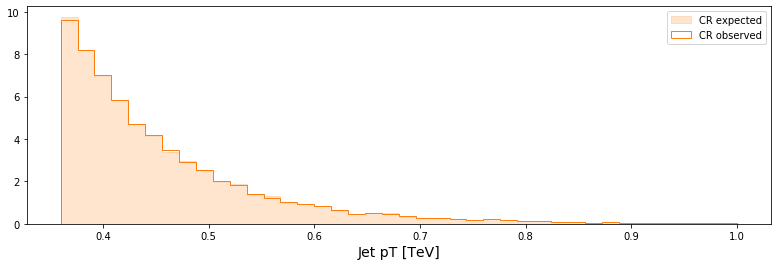

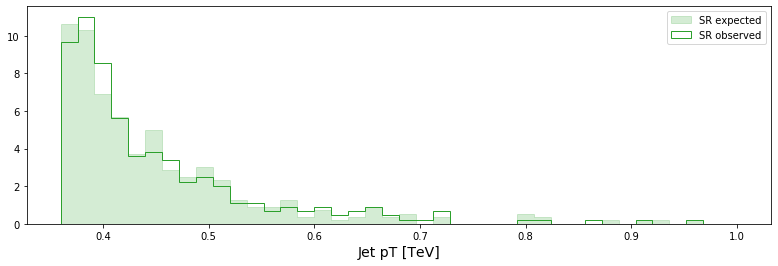

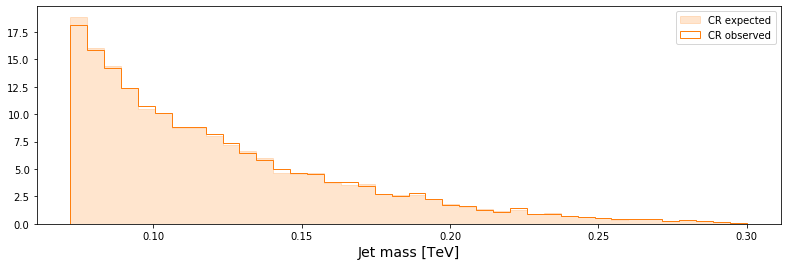

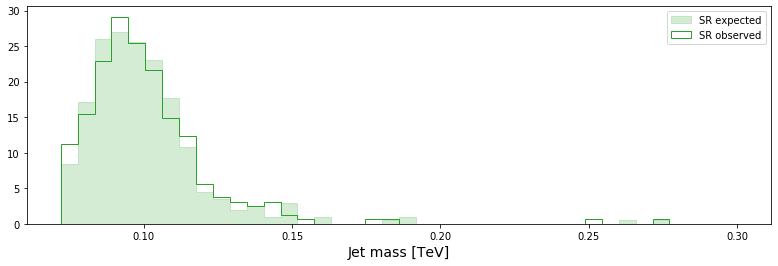

In [595]:
norm = True

hargs = dict(histtype='step', bins=40, range=(JET_PT_MIN,1), density=norm)

plt.figure(figsize=plt.figaspect(0.3));
plt.hist(jpt_val[(y_val==0)*(preds_val[:,0]<CR)*pass_val], color='C1', fill=True, alpha=0.2, label='CR expected', **hargs)
plt.hist(jpt_adv[(y_val==0)*(preds_adv[:,0]<CR)*pass_adv], color='C1', label='CR observed', **hargs);
plt.legend()
plt.xlabel("Jet pT [TeV]")
plt.figure(figsize=plt.figaspect(0.3));
plt.hist(jpt_val[(y_val==0)*(preds_val[:,0]>SR)*pass_val], color='C2', fill=True, alpha=0.2, label='SR expected', **hargs)
plt.hist(jpt_adv[(y_val==0)*(preds_adv[:,0]>SR)*pass_adv], color='C2', label='SR observed', **hargs);
plt.legend()
plt.xlabel("Jet pT [TeV]")

hargs = dict(histtype='step', bins=40, range=(JET_MASS_MIN,0.3), density=norm)
plt.figure(figsize=plt.figaspect(0.3));
plt.hist(jmass_val[(y_val==0)*(preds_val[:,0]<CR)*pass_val], color='C1', fill=True, alpha=0.2, label='CR expected', **hargs)
h = plt.hist(jmass_adv[(y_val==0)*(preds_adv[:,0]<CR)*pass_adv], color='C1', label='CR observed', **hargs);
#plt.errorbar(0.5*(h[1][:-1]+h[1][1:]),h[0],yerr=h[0]/np.sqrt(bg_scale*h[0]), fmt='.', color='C1')
plt.legend()
plt.xlabel("Jet mass [TeV]")
plt.figure(figsize=plt.figaspect(0.3));
plt.hist(jmass_val[(y_val==0)*(preds_val[:,0]>SR)*pass_val], color='C2', fill=True, alpha=0.2, label='SR expected', **hargs)
plt.hist(jmass_adv[(y_val==0)*(preds_adv[:,0]>SR)*pass_adv], color='C2', label='SR observed', **hargs);
plt.legend()
plt.xlabel("Jet mass [TeV]");

print("pT (CR):   ", ks_2samp(jpt_val[(y_val==0)*(preds_val[:,0]<CR)*pass_val], jpt_adv[(y_val==0)*(preds_adv[:,0]<CR)*pass_adv])[:])
print("mass (CR): ", ks_2samp(jmass_val[(y_val==0)*(preds_val[:,0]<CR)*pass_val], jmass_adv[(y_val==0)*(preds_adv[:,0]<CR)*pass_adv])[:])
print()
print("pT (SR):   ", ks_2samp(jpt_val[(y_val==0)*(preds_val[:,0]>SR)*pass_val], jpt_adv[(y_val==0)*(preds_adv[:,0]>SR)*pass_adv])[:])
print("mass (SR): ", ks_2samp(jmass_val[(y_val==0)*(preds_val[:,0]>SR)*pass_val], jmass_adv[(y_val==0)*(preds_adv[:,0]>SR)*pass_adv])[:])

xbest occurs at:  0.87
true xbest:      0.8200000000000001


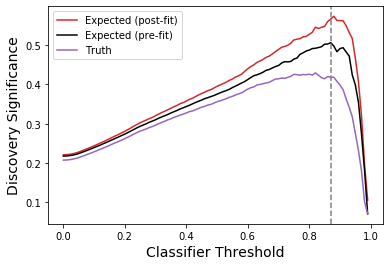

In [596]:
sig_scale = 0.0005
bg_scale = 0.1

thresholds = np.linspace(0,0.99,100)

T = np.expand_dims(thresholds, axis=0)

nsig_before = np.sum(preds_val[(y_val==1)*pass_val] > T, axis=0)
nbg_before = np.sum(preds_val[(y_val==0)*pass_val] > T, axis=0)
nsig_after = np.sum(preds_adv[(y_val==1)*pass_adv] > T, axis=0)
nbg_after = np.sum(preds_adv[(y_val==0)*pass_adv] > T, axis=0)

nsig_total = np.sum((y_val==1)*pass_val)
nbg_total = np.sum((y_val==0)*pass_val)
xbest = np.argmax(z(sig_scale*nsig_before,bg_scale*nbg_before)[nbg_before>0])
cut_best = thresholds[xbest]
print("xbest occurs at: ", cut_best)
print("true xbest:     ", thresholds[np.argmax(z(sig_scale*nsig_after,bg_scale*nbg_after)[nbg_after>0])])

sig_post = z(sig_scale*nsig_before,bg_scale*nbg_after)
sig_exp = z(sig_scale*nsig_before,bg_scale*nbg_before)
sig_true = z(sig_scale*nsig_after,bg_scale*nbg_after)

plt.plot(thresholds, sig_post, label='Expected (post-fit)', color='C3')
plt.plot(thresholds, sig_exp, label='Expected (pre-fit)', color='black')
plt.plot(thresholds, sig_true, label='Truth', color='C4')
#plt.plot(thresholds, z(sig_scale*nsig_after,bg_scale*nbg_before), label='wost')

plt.axvline(thresholds[xbest], ls='--', color='gray')
plt.ylabel('Discovery Significance')
plt.xlabel('Classifier Threshold')
plt.legend();
plt.savefig('significance.pdf')

np.savez('signif_scan_PFN_%d.npz'%defs.N_CONST, thresholds=thresholds, sig_post=sig_post, sig_exp=sig_exp, sig_true=sig_true);

In [597]:
def Q(s,b,n):
    return (1+s/b)**n*np.exp(-s)

from scipy.stats import poisson

In [598]:
nbg_before.shape

(100,)

In [599]:
def cls_scan(obs, bg, sig, sigma_vals):
    sigma_vals = sigma_vals.reshape((1,-1))
    obs = obs.reshape((-1,1))
    b = bg.reshape((-1,1))
    eff = sig.reshape((-1,1))/sig.max()
    return poisson.cdf(obs, b+sigma_vals*eff)/poisson.cdf(obs,b)

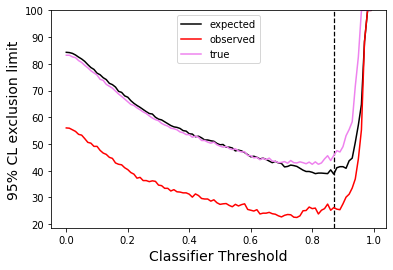

In [600]:
sigma_vals = np.linspace(0,100,1001)

plt.axvline(cut_best, color='black', ls='--', lw=1.25)


cls_exp = cls_scan(bg_scale*nbg_before, bg_scale*nbg_before, nsig_before, sigma_vals)
limits_exp = sigma_vals[np.argmin(np.abs(cls_exp-0.05), axis=-1)]
plt.plot(thresholds, limits_exp,
         color='black', label='expected')


cls_obs = cls_scan(bg_scale*nbg_after, bg_scale*nbg_before, nsig_before, sigma_vals)
limits_obs = sigma_vals[np.argmin(np.abs(cls_obs-0.05), axis=-1)]
plt.plot(thresholds, limits_obs,
         color='red', label='observed')

cls_true = cls_scan(bg_scale*nbg_after, bg_scale*nbg_after, nsig_after, sigma_vals)
limits_true = sigma_vals[np.argmin(np.abs(cls_true-0.05), axis=-1)]
plt.plot(thresholds, limits_true,
         color='violet', label='true')



plt.ylabel("95% CL exclusion limit")
plt.xlabel("Classifier Threshold");
plt.ylim(top=100)
plt.legend();

np.savez('limits_scan_PFN_%d.npz'%defs.N_CONST, thresholds=thresholds, limits_obs=limits_obs,
          limits_true=limits_true, limits_exp=limits_exp, xbest=xbest)

BG exp = 35.800000000000004
BG fudge = 0.8521031207598372
BG post = 30.505291723202173
Sig exp= 3.073
eff exp= 0.3338403041825095
eff obs= 0.2613603473227207
N_obs = 28.400000000000002
limits: 
  expected: 38.7
  observed: 26.200000000000003
      true: 45.7


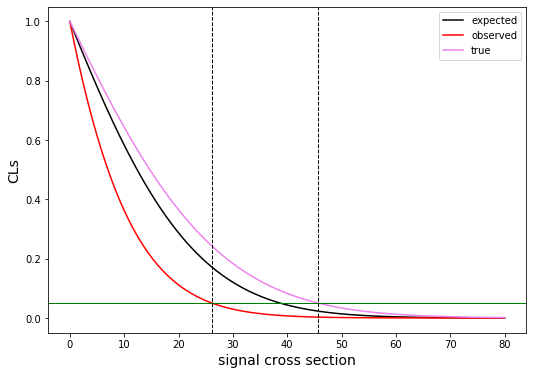

In [601]:
cut = cut_best #0.9


nbg_exp = bg_scale*np.sum(preds_val[(y_val==0)*pass_val]>cut)
nsig_exp = sig_scale*np.sum(preds_val[(y_val==1)*pass_val]>cut)

eff_sig_exp = np.sum(preds_val[(y_val==1)*pass_val]>cut)/np.sum((y_val==1)*pass_val)
eff_sig_obs = np.sum(preds_adv[(y_val==1)*pass_adv]>cut)/np.sum((y_val==1)*pass_adv)

n_obs = bg_scale*np.sum(preds_adv[(y_val==0)*pass_adv]>cut)

#bg_fudge = np.sum((y_val==0)*pass_adv)/np.sum((y_val==0)*pass_val)
bg_fudge = np.sum(preds_adv[(y_val==0)*pass_adv]>CR)/np.sum(preds_val[(y_val==0)*pass_val]>CR)

print("BG exp =", nbg_exp)
print("BG fudge =", bg_fudge)
print("BG post =", nbg_exp*bg_fudge)
print("Sig exp=", nsig_exp)
print("eff exp=", eff_sig_exp)
print("eff obs=", eff_sig_obs)
print("N_obs =", n_obs)

sigma_vals = np.linspace(0,80,801)
CLsb_exp = poisson.cdf(nbg_exp, nbg_exp + sigma_vals*eff_sig_exp)
CLb_exp = poisson.cdf(nbg_exp, nbg_exp)
CLs_exp = CLsb_exp/CLb_exp

CLsb_obs = poisson.cdf(n_obs, nbg_exp + sigma_vals*eff_sig_exp)
CLb_obs = poisson.cdf(n_obs, nbg_exp)
CLs_obs = CLsb_obs/CLb_obs

CLsb_post = poisson.cdf(n_obs, nbg_exp*bg_fudge + sigma_vals*eff_sig_exp)
CLb_post = poisson.cdf(n_obs, nbg_exp*bg_fudge)
CLs_post = CLsb_post/CLb_post

CLsb_true = poisson.cdf(n_obs, n_obs + sigma_vals*eff_sig_obs)
CLb_true = poisson.cdf(n_obs, n_obs)
CLs_true = CLsb_true/CLb_true


plt.figure(figsize=1.5*plt.figaspect(0.7))
plt.plot(sigma_vals, CLs_exp, label='expected', color='black');
plt.plot(sigma_vals, CLs_obs, label='observed', color='red')
#plt.plot(sigma_vals, CLsb_post/CLb_post, label='postfit')
plt.plot(sigma_vals, CLs_true, label='true', color='violet')
plt.legend()
plt.ylabel('CLs')

l_exp = sigma_vals[np.argmin(np.abs(CLs_exp-0.05))]
l_obs = sigma_vals[np.argmin(np.abs(CLs_obs-0.05))]
l_true = sigma_vals[np.argmin(np.abs(CLs_true-0.05))]

plt.axhline(0.05, color='green', lw=1);
plt.axvline(l_obs, lw=1, color='black', ls='--')
plt.axvline(l_true, lw=1, color='black', ls='--')
plt.xlabel("signal cross section");
print("limits: ")
print("  expected:", l_exp)
print("  observed:", l_obs)
print("      true:", l_true)

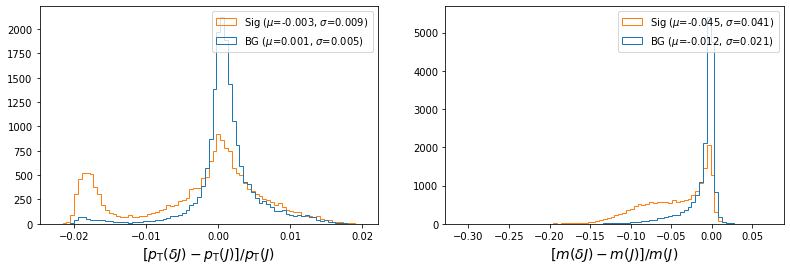

In [602]:
jpt_pull = (jpt_adv-jpt_val)/jpt_val
jmass_pull = (jmass_adv-jmass_val)/jmass_val

plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(121)
jpt_pull_bg = jpt_pull[y_val==0]
jpt_pull_sig = jpt_pull[y_val==1]
#jpt_pull_bg = jpt_pull[(y_val==0)*pass_adv*pass_val]
#jpt_pull_sig = jpt_pull[(y_val==1)*pass_adv*pass_val]
plt.hist([jpt_pull_bg, jpt_pull_sig], histtype='step', bins=80,
         label=[r"BG ($\mu$=%.3f, $\sigma$=%.3f)"%(jpt_pull_bg.mean(),jpt_pull_bg.std()),
                r"Sig ($\mu$=%.3f, $\sigma$=%.3f)"%(jpt_pull_sig.mean(), jpt_pull_sig.std())])
plt.xlabel(r"$[p_\mathrm{T}(\delta J)-p_\mathrm{T}(J)]/p_\mathrm{T}(J)$")
plt.legend();

plt.subplot(122)
jmass_pull_bg = jmass_pull[y_val==0]
jmass_pull_sig = jmass_pull[y_val==1]
#jmass_pull_bg = jmass_pull[(y_val==0)*pass_adv*pass_val]
#jmass_pull_sig = jmass_pull[(y_val==1)*pass_adv*pass_val]
plt.hist([jmass_pull_bg, jmass_pull_sig], histtype='step', bins=80,
         label=[r"BG ($\mu$=%.3f, $\sigma$=%.3f)"%(jmass_pull_bg.mean(),jmass_pull_bg.std()),
                r"Sig ($\mu$=%.3f, $\sigma$=%.3f)"%(jmass_pull_sig.mean(), jmass_pull_sig.std())])
plt.xlabel(r"$[m(\delta J)-m(J)]/m(J)$")
plt.legend();

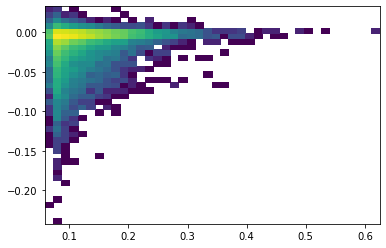

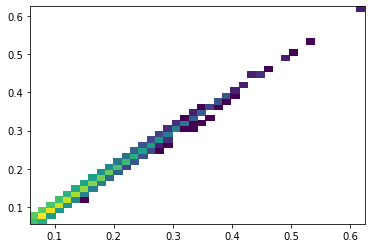

In [603]:
from matplotlib.colors import LogNorm
plt.hist2d(jmass_val[y_val==0],jmass_pull_bg, bins=40, norm=LogNorm());
plt.figure()
plt.hist2d(jmass_val[y_val==0],jmass_adv[y_val==0], bins=40, norm=LogNorm());

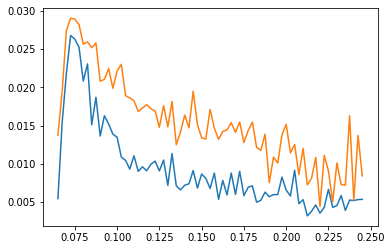

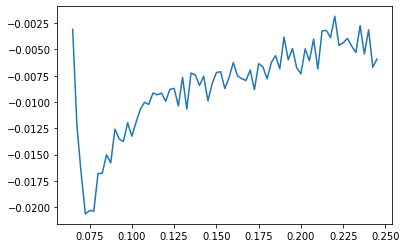

In [604]:
bins = np.arange(0.065,0.25,0.0025)
iqr_bg = [np.diff(np.quantile(jmass_pull_bg[(jmass_val[y_val==0]>=b0)*(jmass_val[y_val==0]<b1)], (0.25,0.75)))[0] for b0,b1 in zip(bins,bins[1:])]
std_bg = [np.std(jmass_pull_bg[(jmass_val[y_val==0]>=b0)*(jmass_val[y_val==0]<b1)]) for b0,b1 in zip(bins,bins[1:])]
mean_bg = [np.mean(jmass_pull_bg[(jmass_val[y_val==0]>=b0)*(jmass_val[y_val==0]<b1)]) for b0,b1 in zip(bins,bins[1:])]

plt.plot(bins[:-1],iqr_bg)
plt.plot(bins[:-1],std_bg)
plt.figure()
plt.plot(bins[:-1],mean_bg);

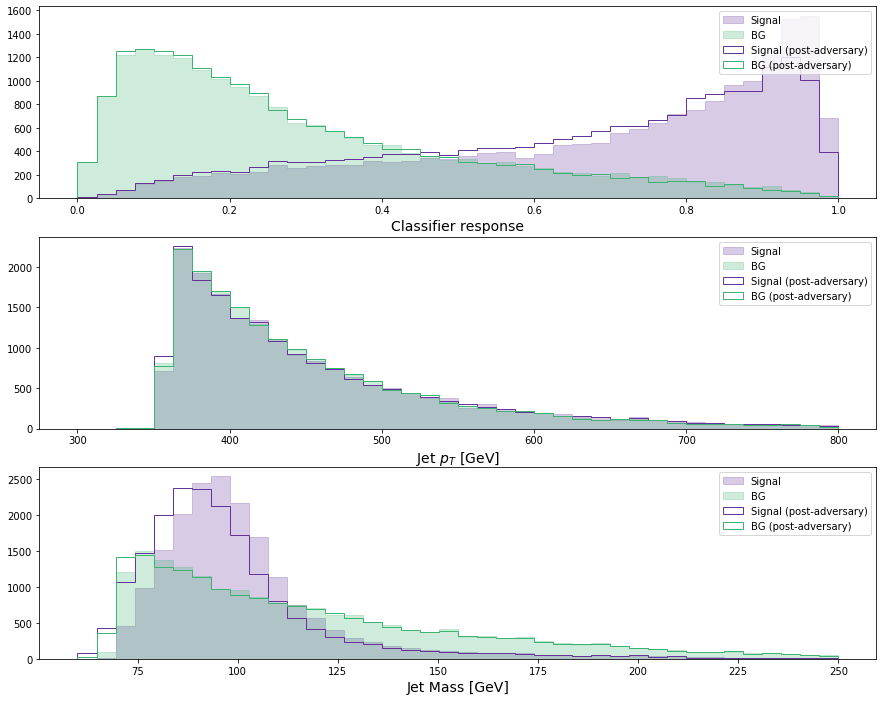

In [632]:
plt.figure(figsize=3*plt.figaspect(0.8))
plt.subplot(3,1,1)
plt.hist([preds_val[y_val==0,0], preds_val[y_val==1,0]], bins=40, range=(0,1), histtype='step',
         fill=True, alpha=0.25, label=['BG', 'Signal'], color=['mediumseagreen','rebeccapurple']);
plt.hist([preds_adv[y_val==0,0], preds_adv[y_val==1,0]], bins=40, range=(0,1), histtype='step',
         label=['BG (post-adversary)','Signal (post-adversary)'], color=['mediumseagreen','rebeccapurple']);
plt.xlabel("Classifier response")
plt.legend()
plt.subplot(3,1,2)
plt.hist([jpt_val[y_val==0]*1e3, jpt_val[y_val==1]*1e3], histtype='step', bins=40,
         range=(defs.JET_PT_MIN*1e3,0.8e3), fill=True, alpha=0.25, label=['BG','Signal'],
         color=['mediumseagreen','rebeccapurple'])
plt.hist([jpt_adv[y_val==0]*1e3, jpt_adv[y_val==1]*1e3], histtype='step', bins=40,
         range=(defs.JET_PT_MIN*1e3,0.8e3), label=['BG (post-adversary)','Signal (post-adversary)'],
         color=('mediumseagreen','rebeccapurple'))
plt.xlabel(r"Jet $p_T$ [GeV]")
plt.legend()
plt.subplot(3,1,3)
plt.hist([jmass_val[y_val==0]*1e3, jmass_val[y_val==1]*1e3], histtype='step', bins=40,
         range=(defs.JET_MASS_MIN*1e3,0.25e3), fill=True, alpha=0.25, label=['BG','Signal'],
         color=('mediumseagreen','rebeccapurple'));
plt.hist([jmass_adv[y_val==0]*1e3, jmass_adv[y_val==1]*1e3], histtype='step', bins=40,
         range=(defs.JET_MASS_MIN*1e3,0.25e3), label=['BG (post-adversary)','Signal (post-adversary)'],
         color=('mediumseagreen','rebeccapurple'));
plt.xlabel("Jet Mass [GeV]")
plt.legend();

plt.savefig('adv_classifer_response.pdf',bbox_inches='tight')


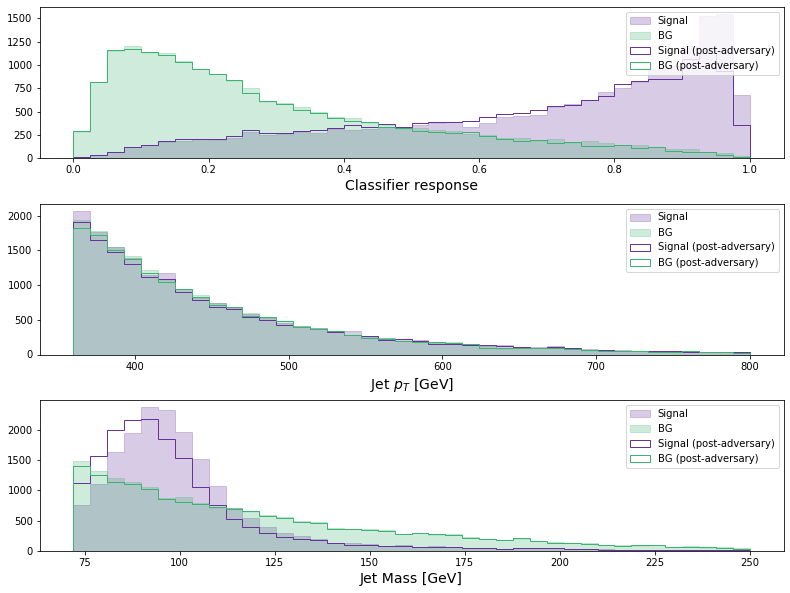

In [606]:
plt.figure(figsize=2.5*plt.figaspect(0.75))
plt.subplot(3,1,1)
plt.hist([preds_val[(y_val==0)*pass_val,0], preds_val[(y_val==1)*pass_val,0]], bins=40, range=(0,1), histtype='step',
         fill=True, alpha=0.25, label=['BG', 'Signal'], color=['mediumseagreen','rebeccapurple']);
plt.hist([preds_adv[(y_val==0)*pass_adv,0], preds_adv[(y_val==1)*pass_adv,0]], bins=40, range=(0,1), histtype='step',
         label=['BG (post-adversary)','Signal (post-adversary)'], color=['mediumseagreen','rebeccapurple']);
plt.xlabel("Classifier response")
plt.legend()
plt.subplot(3,1,2)
plt.hist([jpt_val[(y_val==0)*pass_val]*1e3, jpt_val[(y_val==1)*pass_val]*1e3], histtype='step', bins=40,
         range=(JET_PT_MIN*1e3,0.8e3), fill=True, alpha=0.25, label=['BG','Signal'],
         color=['mediumseagreen','rebeccapurple'])
plt.hist([jpt_adv[(y_val==0)*pass_adv]*1e3, jpt_adv[(y_val==1)*pass_adv]*1e3], histtype='step', bins=40,
         range=(JET_PT_MIN*1e3,0.8e3), label=['BG (post-adversary)','Signal (post-adversary)'],
         color=('mediumseagreen','rebeccapurple'))
plt.xlabel(r"Jet $p_T$ [GeV]")
plt.legend()
plt.subplot(3,1,3)
plt.hist([jmass_val[(y_val==0)*pass_val]*1e3, jmass_val[(y_val==1)*pass_val]*1e3], histtype='step', bins=40,
         range=(JET_MASS_MIN*1e3,0.25e3), fill=True, alpha=0.25, label=['BG','Signal'],
         color=('mediumseagreen','rebeccapurple'));
plt.hist([jmass_adv[(y_val==0)*pass_adv]*1e3, jmass_adv[(y_val==1)*pass_adv]*1e3], histtype='step', bins=40,
         range=(JET_MASS_MIN*1e3,0.25e3), label=['BG (post-adversary)','Signal (post-adversary)'],
         color=('mediumseagreen','rebeccapurple'));
plt.xlabel("Jet Mass [GeV]")
plt.legend();

plt.savefig('adv_classifer_response.pdf',bbox_inches='tight')
plt.subplots_adjust(hspace=0.3);

0.521383513311237 0.07756869453651236


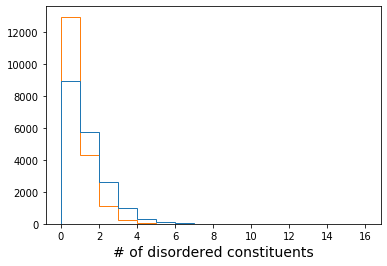

In [607]:
disorder = np.sum(np.diff(pt_adv, axis=-1)>0, axis=-1)
plt.hist([disorder[y_val==0], disorder[y_val==1]], histtype='step', bins=16, range=(0,16));
plt.xlabel("# of disordered constituents")
print(np.mean(disorder[y_val==0]>0), np.mean(disorder[y_val==1]>1))